# Imports Tools and Libraries

In [34]:
# ============================================
# 📦 Core Libraries
# ============================================
import os
import numpy as np
import pandas as pd
import warnings
from textwrap import wrap

# ============================================
# 📊 Visualization
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# ============================================
# ⚙️ Progress Bar
# ============================================
from tqdm import tqdm

# ============================================
# 🤖 TensorFlow & Keras Core
# ============================================
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ============================================
# 🧠 Layers
# ============================================
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten,
    Dense, Input, Layer, Embedding, LSTM, Bidirectional, add, concatenate,
    Concatenate, Reshape
)

# ============================================
# 🧾 Data Preprocessing
# ============================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical

# ============================================
# 🧬 Pretrained Models
# ============================================
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201

# 🖼️ Image Captioning

## ❓ What is Image Captioning?

- **Image Captioning** is the process of generating a **textual description of an image**.  
  It combines **Computer Vision** and **Natural Language Processing (NLP)** techniques to automatically generate meaningful captions.

- This task lies at the **intersection of Computer Vision and Natural Language Processing**.  
  Most image captioning systems follow an **encoder–decoder architecture**, where:
  - The **encoder** converts the input image into an intermediate feature representation.
  - The **decoder** transforms this representation into a **descriptive natural language sentence**.

---

## 🧠 CNNs + RNNs (LSTMs)

- To perform **Image Captioning**, we combine **two deep learning models** into a single architecture during training.

- **Convolutional Neural Networks (CNNs)** are used to:
  - Extract visual features from the input image
  - Represent the image as a **fixed-length feature vector (embedding)**
  - The size of this embedding depends on the **pretrained CNN model** used (e.g., VGG, ResNet, Inception)

- **Recurrent Neural Networks (RNNs)**, especially **Long Short-Term Memory (LSTM)** networks, are used for:
  - **Text generation**
  - Predicting the next word in the caption sequence

- The **image embeddings** produced by the CNN are:
  - Combined (concatenated) with **word embeddings**
  - Passed into the **LSTM**, which generates captions **word by word**

- For a more intuitive understanding of this architecture, refer to the **Modelling section**, where a **visual representation** of the CNN–LSTM pipeline is shown.

---


# Load Dataset

In [23]:
image_path = '/kaggle/input/flickr8k/Images'
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# Visualization

- Images and Their Corresponding Captions

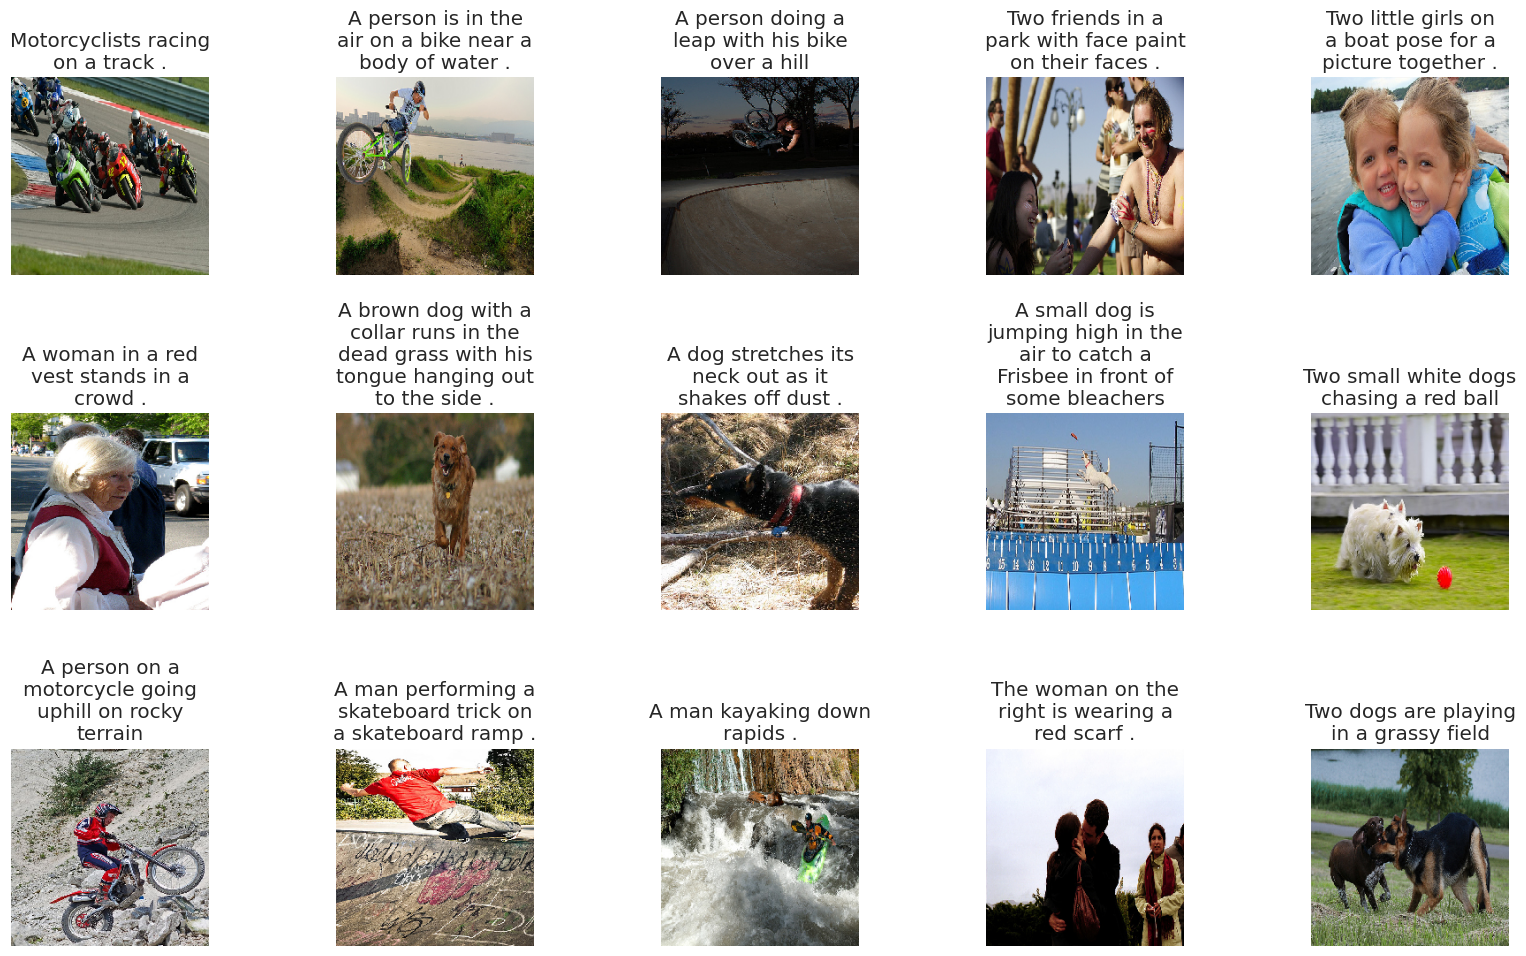

In [24]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode ='rgb' , target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255  ## normalize in range 0 to 1
    return img
               
def view_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7 , wspace=0.3)
        image = readImage(f"/kaggle/input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i],20)))
        plt.axis("off")
    


view_images(data.sample(15))

## 📝 Caption Text Preprocessing Steps

- Convert all sentences to **lowercase**
- Remove **special characters** and **numbers** from the text
- Remove **extra spaces**
- Remove **single-character tokens**
- Add a **start tag** and an **end tag** to each sentence to indicate the **beginning** and **end** of a caption


In [25]:
def wrap_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())  # Girl != girl
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data 
    
data = wrap_preprocessing(data)

captions = data['caption'].tolist()

captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## 🔢 Tokenization and Encoded Representation

- The words in a sentence are **separated (tokenized)** and encoded using a **one-hot representation**
- These encoded vectors are then passed through an **Embedding layer** to generate **dense word embeddings**

### 🔍 Example

Consider the sentence:

> **"I saw a cat."**

Each word is mapped to a **token index** in the vocabulary, for example:

- `I` → 39  
- `saw` → 1592  
- `a` → 10  
- `cat` → 2548  
- `.` → 5  

These token indices are then transformed into **dense vectors** using an embedding layer with a fixed **embedding dimension**, producing meaningful numerical representations of words while considering the **vocabulary size**.


In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

## 🧩 Image Feature Extraction

- **DenseNet201 architecture** is used to extract high-level features from images.
- Any other **pretrained CNN architecture** (such as ResNet, Inception, EfficientNet, etc.) can also be used for feature extraction.
- Since the **Global Average Pooling (GAP)** layer is chosen as the final layer of the DenseNet201 model, the resulting **image embeddings** are represented as a fixed-length vector of size **1920**.

### 🧠 Feature Extraction Pipeline (DenseNet-based)

The input image is passed through multiple convolutional and dense blocks, followed by pooling layers.  
Finally, the Global Average Pooling layer converts spatial feature maps into a compact feature vector that can be used by downstream models such as an **LSTM decoder** for caption generation.

![CNN Feature Extraction Architecture](https://miro.medium.com/v2/resize:fit:1400/1*FZqzV2k8oK8k4qz6ZQxZ_g.png)



In [27]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1768805498.127181     168 service.cc:152] XLA service 0x7f0cac003750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768805498.127222     168 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768805498.127225     168 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768805501.061662     168 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768805517.844020     168 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [14:56<00:00,  9.02it/s]


## ⚙️ Data Generation

- Training an **Image Captioning model**, like any other **neural network**, is a highly **resource-intensive process**.  
  Therefore, it is not feasible to load the entire dataset into main memory at once.

- To handle this efficiently, the data is generated **batch-wise** in the required format during training.

- The model inputs consist of:
  - **Image embeddings** extracted from a CNN
  - Corresponding **caption text embeddings** for supervised learning

- During **inference time**, the caption is generated **word by word**, where the text embeddings are sequentially passed to the model to predict the next word in the caption.


In [28]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [29]:
train_generator[0]

((array([[7.8687917e-05, 7.3524046e-04, 1.1395992e-03, ..., 5.6523514e-01,
          2.2903694e-01, 6.9639701e-01],
         [7.8687917e-05, 7.3524046e-04, 1.1395992e-03, ..., 5.6523514e-01,
          2.2903694e-01, 6.9639701e-01],
         [7.8687917e-05, 7.3524046e-04, 1.1395992e-03, ..., 5.6523514e-01,
          2.2903694e-01, 6.9639701e-01],
         ...,
         [1.9476042e-04, 7.0213032e-04, 1.4947484e-03, ..., 2.7233722e-02,
          5.5759633e-01, 3.8916701e-01],
         [1.9476042e-04, 7.0213032e-04, 1.4947484e-03, ..., 2.7233722e-02,
          5.5759633e-01, 3.8916701e-01],
         [1.9476042e-04, 7.0213032e-04, 1.4947484e-03, ..., 2.7233722e-02,
          5.5759633e-01, 3.8916701e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

## 🧠 Modelling

- The **image embedding representation** is concatenated with the **first word of the caption** (i.e., the `startseq` token) and passed as input to the **LSTM network**.

- The **LSTM** generates the caption **word by word**, producing a new word after each input step and continuing this process until a complete sentence is formed.


In [35]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)




history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 5.6667
Epoch 1: val_loss improved from inf to 4.27308, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 134ms/step - loss: 5.6656 - val_loss: 4.2731 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 4.3127
Epoch 2: val_loss improved from 4.27308 to 3.95069, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 70s 131ms/step - loss: 4.3126 - val_loss: 3.9507 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 4.0010
Epoch 3: val_loss improved from 3.95069 to 3.79876, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 71s 131ms/step - loss: 4.0009 - val_loss: 3.7988 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 3.8194
Epoch 4: val_loss improved from 3.79876 to 3.71535, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 70s 130ms/step - loss: 3.8194 - val_loss: 3.7154 - learning_rate: 0.0010


## 📈 Learning Curve

- The model shows clear signs of **overfitting**, possibly due to the **limited size of the training dataset**.

- This issue can be addressed in the following ways:
  1. Train the model on a **larger dataset** such as **Flickr40k**
  2. Incorporate **Attention-based models** to improve caption generation performance


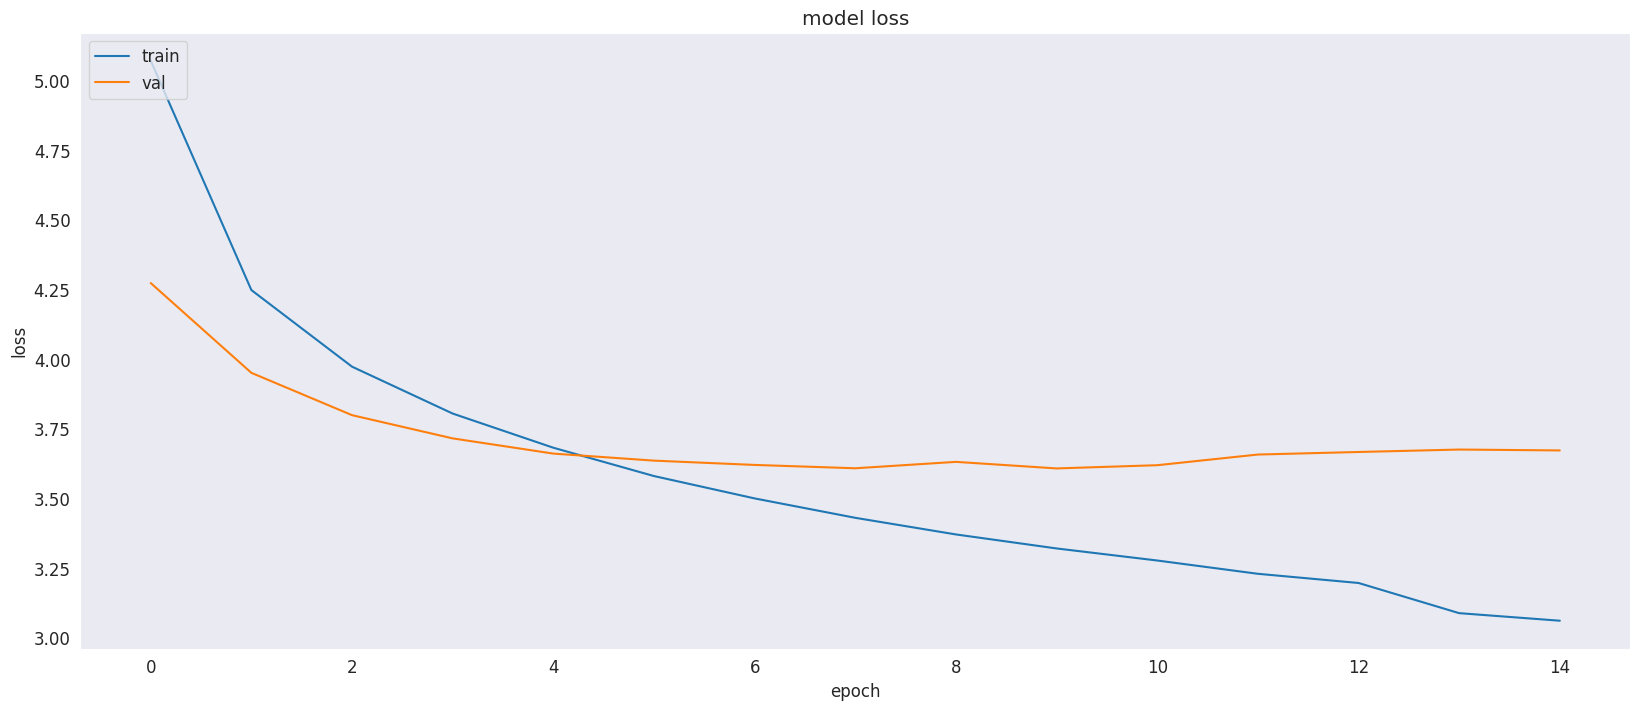

In [36]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 🛠️ Caption Generation Utility Functions

- Utility functions are used to **generate captions for input images during inference time**.

- The **image embeddings** are passed to the model along with the **first word** of the caption sequence (`startseq`).

- Afterward, the **text embedding of each newly generated word** is fed back into the model to predict the **next word**, continuing this process until the complete caption is generated.


In [37]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [38]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

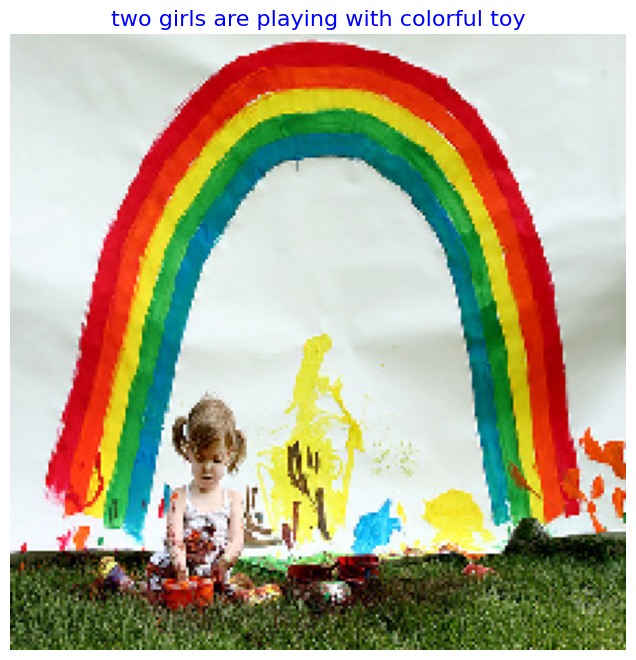

In [39]:
# Example usage
image_path = "/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

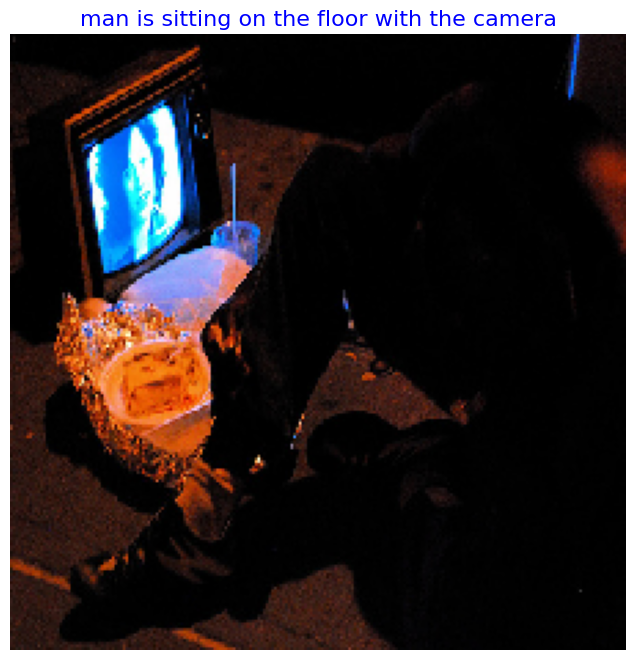

In [40]:
image_path = "/kaggle/input/flickr8k/Images/1045521051_108ebc19be.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

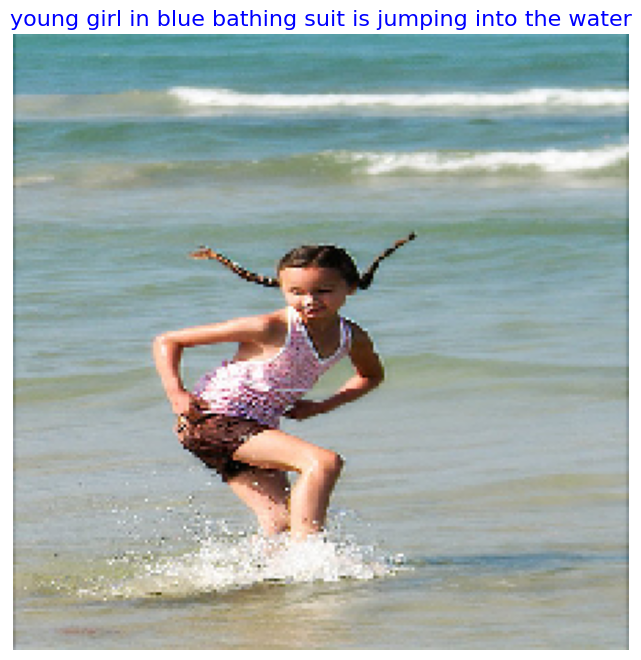

In [41]:
image_path = "/kaggle/input/flickr8k/Images/1053804096_ad278b25f1.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)